In [6]:
import pandas as pd
import numpy as np

# Load your existing 1000-record dataset
df = pd.read_csv("mock_survey_data_realistic_1000.csv")
# --- Encode categorical to numeric for feature engineering ---
map_vals = {"No":0, "Sometimes":1, "Often":2, "None":0, "One":1, "Multiple":2}
df["physical_activity_num"] = df["physical_activity"].map(map_vals)
df["alcohol_num"] = df["alcohol_drinks_week"].map(map_vals)
df["screen_num"] = df["screen_time_after_11"].map(map_vals)
df["family_history_num"] = df["family_history_diabetes"].map(map_vals)

# --- Engineered features ---
df["bmi_category"] = pd.cut(df["bmi"],
                            bins=[0,18.5,24.9,29.9,100],
                            labels=[0,1,2,3]).astype(int)  # under, normal, overweight, obese
df["sleep_debt"] = np.where(df["sleep_hours"] < 7, 1, 0)
df["stress_index"] = df["feeling_hopeless"] + (3 - df["interest_in_doing_stuff"]) + df["sleep_debt"]
df["sedentary_score"] = df["screen_num"] + (2 - df["physical_activity_num"])

# --- Probabilistic outcome generators ---
rng = np.random.default_rng()

def prob_label(prob):
    """Return 1 with probability=prob, else 0"""
    return 1 if rng.random() < prob else 0

outcomes = {
    "diabetes_future": [],
    "hypertension_future": [],
    "cholesterol_future": [],
    "coronary_hd_future": [],
    "sleep_apnea_future": [],
    "insomnia_future": [],
    "migraine_future": [],
    "depression_future": [],
    "anxiety_future": [],
    "obesity_future": [],
    "gerd_future": [],
    "wellness_decline_future": []
}

for _, row in df.iterrows():
    # Diabetes
    base = 0.1
    if row["bmi"] >= 30: base += 0.3
    if row["family_history_num"] > 0: base += 0.2
    if row["sleep_hours"] < 6: base += 0.15
    outcomes["diabetes_future"].append(prob_label(min(base,0.95)))
    
    # Hypertension
    base = 0.1
    if row["bmi"] >= 27: base += 0.25
    if row["high_blood_pressure"] == 1: base += 0.3
    if row["alcohol_num"] == 2: base += 0.2
    outcomes["hypertension_future"].append(prob_label(min(base,0.95)))
    
    # Cholesterol
    base = 0.1
    if row["high_cholesterol_prediabetes"] == 1: base += 0.4
    if row["bmi"] >= 28: base += 0.2
    outcomes["cholesterol_future"].append(prob_label(min(base,0.9)))
    
    # Coronary Heart Disease (depends on diabetes, hypertension, cholesterol)
    risk = (0.2 * outcomes["diabetes_future"][-1] +
            0.2 * outcomes["hypertension_future"][-1] +
            0.2 * outcomes["cholesterol_future"][-1] +
            (row["age"] > 50) * 0.2)
    outcomes["coronary_hd_future"].append(prob_label(min(risk+0.1,0.95)))
    
    # Sleep Apnea
    base = 0.05
    if row["bmi"] >= 32: base += 0.3
    if row["sexAtBirth"] == "male": base += 0.1
    if row["sleep_hours"] < 6: base += 0.15
    outcomes["sleep_apnea_future"].append(prob_label(min(base,0.9)))
    
    # Insomnia
    base = 0.05
    if row["sleep_hours"] < 5.5: base += 0.4
    if row["screen_num"] == 2: base += 0.2
    if row["caffeine_mg"] > 400: base += 0.15
    outcomes["insomnia_future"].append(prob_label(min(base,0.9)))
    
    # Migraine
    base = 0.05
    if row["sleep_hours"] < 6: base += 0.2
    if row["caffeine_mg"] > 300: base += 0.2
    if row["screen_num"] == 2: base += 0.2
    outcomes["migraine_future"].append(prob_label(min(base,0.85)))
    
    # Depression
    base = 0.1
    if row["stress_index"] >= 5: base += 0.3
    if (row["interest_in_doing_stuff"] + row["feeling_hopeless"]) >= 3: base += 0.3
    outcomes["depression_future"].append(prob_label(min(base,0.95)))
    
    # Anxiety
    base = 0.1
    if row["caffeine_mg"] > 350: base += 0.2
    if row["screen_num"] == 2: base += 0.2
    if row["feeling_hopeless"] >= 2: base += 0.2
    outcomes["anxiety_future"].append(prob_label(min(base,0.9)))
    
    # Obesity
    base = 0.05
    if row["bmi"] >= 30: base += 0.4
    if row["physical_activity_num"] == 0: base += 0.2
    outcomes["obesity_future"].append(prob_label(min(base,0.95)))
    
    # GERD / Acid Reflux
    base = 0.05
    if row["alcohol_num"] == 2: base += 0.3
    if row["bmi"] >= 28: base += 0.2
    outcomes["gerd_future"].append(prob_label(min(base,0.9)))
    
    # Wellness Decline (composite: 3+ conditions positive)
    risk_sum = (outcomes["diabetes_future"][-1] + outcomes["hypertension_future"][-1] +
                outcomes["cholesterol_future"][-1] + outcomes["coronary_hd_future"][-1] +
                outcomes["sleep_apnea_future"][-1] + outcomes["insomnia_future"][-1] +
                outcomes["migraine_future"][-1] + outcomes["depression_future"][-1] +
                outcomes["anxiety_future"][-1] + outcomes["obesity_future"][-1] +
                outcomes["gerd_future"][-1])
    outcomes["wellness_decline_future"].append(1 if risk_sum >= 3 else 0)

# Attach new outcomes
for k,v in outcomes.items():
    df[k] = v

# Save expanded dataset
print("✅ Added 10+ disease outcomes with probabilistic labels!")


✅ Added 10+ disease outcomes with probabilistic labels!


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Feature columns
feature_cols = ["bmi","sleep_hours","caffeine_mg",
                "physical_activity_num","alcohol_num","screen_num",
                "family_history_num","bmi_category","sleep_debt",
                "stress_index","sedentary_score"]

diseases = ["diabetes_future","hypertension_future","cholesterol_future",
            "coronary_hd_future","sleep_apnea_future","insomnia_future",
            "migraine_future","depression_future","anxiety_future",
            "obesity_future","gerd_future","wellness_decline_future"]

models = {}

# Imputer for NaN values
imputer = SimpleImputer(strategy="median")

for disease in diseases:
    X = df[feature_cols]
    y = df[disease]
    
    # Impute missing values
    X_imputed = imputer.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"{disease}: ROC AUC = {auc:.2f}")
    
    models[disease] = (clf, imputer)  # store model + imputer for use in predictions


diabetes_future: ROC AUC = 0.69
hypertension_future: ROC AUC = 0.67
cholesterol_future: ROC AUC = 0.54
coronary_hd_future: ROC AUC = 0.55
sleep_apnea_future: ROC AUC = 0.63
insomnia_future: ROC AUC = 0.76
migraine_future: ROC AUC = 0.77
depression_future: ROC AUC = 0.65
anxiety_future: ROC AUC = 0.65
obesity_future: ROC AUC = 0.74
gerd_future: ROC AUC = 0.77
wellness_decline_future: ROC AUC = 0.75


In [25]:
def predict_from_survey(age, sex, ethnicity, height_ft, height_in, weight_lb,
                        sleep_hours, physical_activity, alcohol, screen,
                        caffeine_mg, family_history, interest, hopeless,
                        high_bp=0, high_chol=0):
    # Encoding maps
    map_vals = {"No":0, "Sometimes":1, "Often":2, "None":0, "One":1, "Multiple":2}
    
    # Height → BMI
    height_total = height_ft*12 + height_in
    bmi = round((weight_lb / (height_total**2)) * 703, 1)
    
    # Encoded lifestyle
    physical_activity_num = map_vals[physical_activity]
    alcohol_num = map_vals[alcohol]
    screen_num = map_vals[screen]
    family_history_num = map_vals[family_history]
    
    # Engineered features
    bmi_category = int(pd.cut([bmi], bins=[0,18.5,24.9,29.9,100],
                              labels=[0,1,2,3])[0])
    sleep_debt = 1 if sleep_hours < 7 else 0
    stress_index = hopeless + (3 - interest) + sleep_debt
    sedentary_score = screen_num + (2 - physical_activity_num)
    
    # Build feature dict
    input_dict = {
        "bmi": bmi,
        "sleep_hours": sleep_hours,
        "caffeine_mg": caffeine_mg,
        "physical_activity_num": physical_activity_num,
        "alcohol_num": alcohol_num,
        "screen_num": screen_num,
        "family_history_num": family_history_num,
        "bmi_category": bmi_category,
        "sleep_debt": sleep_debt,
        "stress_index": stress_index,
        "sedentary_score": sedentary_score
    }
    
    # Predict risks
    features = pd.DataFrame([input_dict])
    results = {}
    for disease, (clf, imputer) in models.items():
        features_imp = imputer.transform(features)
        prob = clf.predict_proba(features_imp)[:,1][0]
        results[disease] = round(prob, 3)
    
    return results


In [26]:
patient = predict_from_survey(
    age=45, sex="male", ethnicity="Asian",
    height_ft=5, height_in=10, weight_lb=200,
    sleep_hours=5.5,
    physical_activity="Often",
    alcohol="Often",
    screen="Often",
    caffeine_mg=200,
    family_history="Multiple",
    interest=1, hopeless=2,
    high_bp=1, high_chol=1
)

print(patient)


{'diabetes_future': 0.35, 'hypertension_future': 0.505, 'cholesterol_future': 0.47, 'coronary_hd_future': 0.41, 'sleep_apnea_future': 0.08, 'insomnia_future': 0.295, 'migraine_future': 0.16, 'depression_future': 0.295, 'anxiety_future': 0.375, 'obesity_future': 0.06, 'gerd_future': 0.415, 'wellness_decline_future': 0.65}


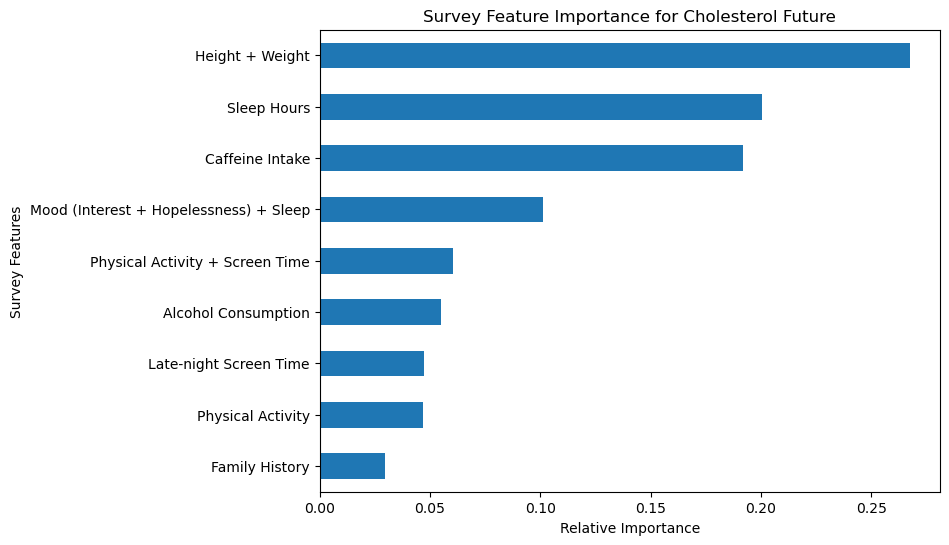

In [27]:
# Map engineered features to survey features
survey_map = {
    "bmi": "Height + Weight",
    "bmi_category": "Height + Weight",
    "sleep_hours": "Sleep Hours",
    "sleep_debt": "Sleep Hours",
    "caffeine_mg": "Caffeine Intake",
    "physical_activity_num": "Physical Activity",
    "sedentary_score": "Physical Activity + Screen Time",
    "alcohol_num": "Alcohol Consumption",
    "screen_num": "Late-night Screen Time",
    "family_history_num": "Family History",
    "stress_index": "Mood (Interest + Hopelessness) + Sleep"
}

def plot_survey_importance(disease):
    clf, imputer = models[disease]
    importances = pd.Series(clf.feature_importances_, index=feature_cols)
    
    # Collapse engineered → survey level
    survey_importances = {}
    for feat, score in importances.items():
        parent = survey_map[feat]
        survey_importances[parent] = survey_importances.get(parent, 0) + score
    
    survey_series = pd.Series(survey_importances).sort_values()
    
    # Plot
    plt.figure(figsize=(8,6))
    survey_series.plot(kind="barh")
    plt.title(f"Survey Feature Importance for {disease.replace('_',' ').title()}")
    plt.xlabel("Relative Importance")
    plt.ylabel("Survey Features")
    plt.show()

# Example: for Diabetes
plot_survey_importance("cholesterol_future")



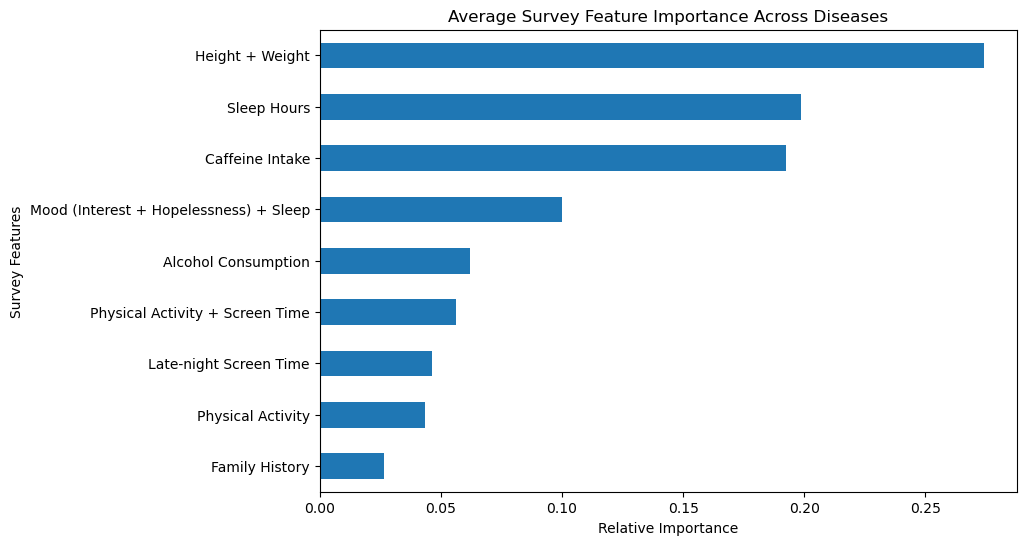

In [28]:
# feature columns from training step
feature_cols = ["bmi","sleep_hours","caffeine_mg",
                "physical_activity_num","alcohol_num","screen_num",
                "family_history_num","bmi_category","sleep_debt",
                "stress_index","sedentary_score"]

# Map engineered features to raw survey-level
survey_map = {
    "bmi": "Height + Weight",
    "bmi_category": "Height + Weight",
    "sleep_hours": "Sleep Hours",
    "sleep_debt": "Sleep Hours",
    "caffeine_mg": "Caffeine Intake",
    "physical_activity_num": "Physical Activity",
    "sedentary_score": "Physical Activity + Screen Time",
    "alcohol_num": "Alcohol Consumption",
    "screen_num": "Late-night Screen Time",
    "family_history_num": "Family History",
    "stress_index": "Mood (Interest + Hopelessness) + Sleep"
}

# Calculate average feature importances across all diseases at survey level
all_importances = pd.DataFrame([
    models[d][0].feature_importances_ for d in models.keys()
], columns=feature_cols, index=models.keys())

# Collapse engineered → survey
survey_importances = {}
for feat in feature_cols:
    parent = survey_map[feat]
    survey_importances[parent] = survey_importances.get(parent, 0) + all_importances[feat].mean()

survey_series = pd.Series(survey_importances).sort_values()

# Plot survey-level importance
plt.figure(figsize=(9,6))
survey_series.plot(kind="barh")
plt.title("Average Survey Feature Importance Across Diseases")
plt.xlabel("Relative Importance")
plt.ylabel("Survey Features")
plt.show()
